## Refine Neural cell annotations for large intestine - relabelling uncertain cells based on manual inspection/majority voting

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import os
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import ast

In [2]:
sc.logging.print_header()

scanpy==1.8.0 anndata==0.8.0 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.3.5 scikit-learn==0.24.1 statsmodels==0.13.5 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.2


In [3]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [4]:
sc.set_figure_params(
    dpi=200,dpi_save=300,
    fontsize=12,
    frameon=False,
    transparent=True,
)

In [5]:
sns.set_style(style="white")
sns.set_context(context="paper")

### Import

In [6]:
#import data
adata = sc.read_h5ad('/nfs/team205/ao15/Megagut/Annotations_v3/h5ad/disease/compartments/Neural_pooled_disease.gene_cellbender.good_qc_cluster_mito80.stringent_doublet_removed.hvg7500_noCC.scvi_output.lv20_batch256.with_raw_counts.scArches_broad_pred.20230124.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 918 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_splic

In [8]:
#import scanvi coordinates
adata_scanvi = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/X_scANVI/disease/disease_fine_annot_predict_Neural_20230226.csv.gz',compression='gzip',index_col=0)

In [9]:
adata_scanvi

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,LV11,LV12,LV13,LV14,LV15,LV16,LV17,LV18,LV19,LV20
index,,,,,,,,,,,,,,,,,,,,
AGATTGCCACGGCGTT-4918STDY7273965,1.018063,0.059804,-0.111304,-0.015835,-0.012391,-0.148775,0.842993,0.407187,-0.008121,0.044807,0.998976,-0.710062,-0.023280,0.039419,-0.210453,0.040061,-0.010519,0.424893,0.879213,1.171482
CGCGGTACACCACCAG-4918STDY7273965,1.082431,0.735878,0.108178,0.031474,-0.019515,0.021328,-0.537078,-0.158741,0.038754,0.073929,1.171954,0.036917,-0.015580,0.056321,-0.108313,-0.101220,-0.016497,0.420990,-0.126369,0.528322
CGGCTAGGTCTAAACC-4918STDY7273965,1.118317,0.455973,0.089076,0.027486,0.010920,-0.005920,0.738456,-0.419733,-0.028139,0.046208,0.156494,-0.145971,-0.052200,0.044296,-0.160103,-0.096941,-0.054310,0.660461,0.743833,1.089818
TGTTCCGCACGTTGGC-4918STDY7273965,0.955482,0.159910,0.137635,0.047401,-0.095582,0.090132,0.650742,-0.263154,0.027028,0.047748,2.472093,0.084613,0.124205,0.108528,-0.150173,-0.265505,-0.066190,-0.195954,0.090523,0.934214
AAGCCGCTCATTGCGA-4918STDY7901096,1.149764,0.311420,0.014952,0.097484,0.014491,0.104874,0.517444,-0.447497,-0.050986,0.107814,1.175487,-1.501831,0.007502,0.049957,-0.115236,-0.349177,-0.107268,-0.387387,0.151109,-0.197140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGACAACGTATTAGCC-GSM4546323,1.232899,0.524336,-0.109674,0.029465,-0.026759,0.191961,-0.545949,-1.036548,0.096315,0.101230,2.022488,-1.444689,-0.050304,0.070028,-0.246419,-0.437331,-0.162040,-0.194617,1.217164,0.686348
TGACAACGTGCAACTT-GSM4546323,0.645532,0.876331,0.329496,0.009167,0.008858,-0.031815,0.116321,0.006070,0.038363,0.071376,1.601253,-0.099176,-0.011285,0.052232,-0.221492,-0.055646,-0.056697,-0.348352,1.090412,0.934350
TGGTTAGTCTGCAAGT-GSM4546323,0.594002,0.443153,0.126700,-0.070866,0.078296,-0.083717,0.270406,0.585430,0.046190,0.118339,2.415874,-0.901776,-0.036508,0.037582,-0.204494,-0.123053,-0.065433,-1.282450,1.131627,1.298928


In [10]:
adata.obsm['X_scANVI'] = adata_scanvi

In [11]:
#import metadata
adata_meta = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/disease/20230308/scanvi/disease_fine_annot_predict_Neural_20230226.csv',index_col=0)

In [12]:
adata_meta

,latent_cell_probability,latent_RT_efficiency,cecilia22_predH,cecilia22_predH_prob,cecilia22_predH_uncertain,cecilia22_predL,cecilia22_predL_prob,cecilia22_predL_uncertain,elmentaite21_pred,elmentaite21_pred_prob,...,martin19_pred_uncertain,warner20_pred,warner20_pred_prob,warner20_pred_uncertain,broad_predicted_labels,broad_predicted_labels_uncert,fine_annot,fine_predicted_labels,fine_predicted_labels_uncertainty,scanvi_pred
index,,,,,,,,,,,,,,,,,,,,,
AGATTGCCACGGCGTT-4918STDY7273965,0.999891,2.379928,B cells,0.332422,B cells,Naive B cells,0.033330,Uncertain,Adult Glia,1.000000,...,Glial,Glia,0.760454,Glia,Neural,0.000000e+00,Unknown,Glial_2,0.379937,Glial_1
CGCGGTACACCACCAG-4918STDY7273965,0.999190,0.858533,B cells,0.317386,B cells,Naive B cells,0.056494,Uncertain,Adult Glia,0.952124,...,Glial,Glia,0.288670,Uncertain,Neural,3.996706e-02,Unknown,Glial/Enteric_neural_crest,0.440043,Doublets
CGGCTAGGTCTAAACC-4918STDY7273965,0.999796,1.777499,B cells,0.000131,Uncertain,Naive B cells,0.000106,Uncertain,Adult Glia,1.000000,...,Glial,Glia,0.714854,Glia,Neural,0.000000e+00,Unknown,Glial_2,0.399951,Glial_2
TGTTCCGCACGTTGGC-4918STDY7273965,0.999913,3.098696,B cells,0.014442,Uncertain,Naive B cells,0.001702,Uncertain,Adult Glia,0.999943,...,Glial,Glia,0.711413,Glia,Neural,0.000000e+00,Unknown,Doublets,0.299830,Doublets
AAGCCGCTCATTGCGA-4918STDY7901096,0.999107,0.885663,DC,0.434722,DC,NK cells,0.673673,NK cells,Adult Glia,0.888223,...,Glial,Glia,0.111564,Uncertain,Neural,1.000562e-01,Unknown,Doublets,0.599855,Doublets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGACAACGTATTAGCC-GSM4546323,0.999376,0.855488,T cells,0.045342,Uncertain,NK cells,0.181932,Uncertain,Pericyte,0.999872,...,Glial,Glia,0.330089,Glia,Neural,2.001113e-02,Unknown,Doublets,0.519983,Doublets
TGACAACGTGCAACTT-GSM4546323,0.999259,0.901315,T cells,0.010240,Uncertain,NK cells,0.010278,Uncertain,Pericyte,0.999986,...,Glial,Glia,0.380365,Glia,Neural,0.000000e+00,Unknown,Glial_2,0.399775,Glial_2
TGGTTAGTCTGCAAGT-GSM4546323,0.999560,0.767289,T cells,0.076587,Uncertain,NK cells,0.323420,NK cells,Pericyte,0.038644,...,Glial,Glia,0.125888,Uncertain,Neural,1.400370e-01,Unknown,Doublets,0.539043,Doublets


In [13]:
adata.obs = adata_meta

### Process

In [14]:
#compute neighbours and umap
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


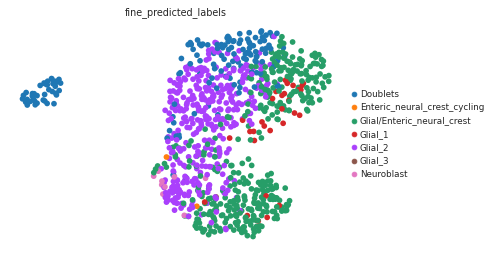

In [15]:
sc.pl.umap(adata, color=['fine_predicted_labels'])

In [16]:
adata.obs.donor_disease.unique()

['PIBD', 'cancer', 'UC', 'CD']
Categories (4, object): ['CD', 'PIBD', 'UC', 'cancer']

In [17]:
#fix metadata
adata.obs['disease'] = adata.obs['donor_category'].astype(str) + '_' + adata.obs['donor_disease'].astype(str)

In [18]:
list(adata.obs.disease.unique())

['disease_PIBD', 'disease_cancer', 'disease_UC', 'disease_CD']

In [19]:
adata.obs.disease.value_counts()

disease_UC        499
disease_cancer    149
disease_CD        141
disease_PIBD      129
Name: disease, dtype: int64

In [20]:
adata.obs.donor_disease.unique()

['PIBD', 'cancer', 'UC', 'CD']
Categories (4, object): ['CD', 'PIBD', 'UC', 'cancer']

In [21]:
adata.obs['disease'] = (adata.obs['disease'].map(lambda x:{
'disease_cancer':'cancer',
    'disease_PIBD':'pediatric_IBD',
    'disease_UC':'ulcertaive_colitis',
    'disease_CD':'crohns_disease'
    }.get(x,x)).astype("category"))

In [22]:
cancer = adata[adata.obs['disease'].isin(['cancer'])].copy()

In [23]:
cancer.obs.disease.value_counts()

cancer    149
Name: disease, dtype: int64

In [24]:
cancer.obs['disease'] = cancer.obs['disease'].astype(str) + '_' + cancer.obs['organ_unified'].astype(str)

In [25]:
cancer.obs.disease.value_counts()

cancer_stomach            45
cancer_rectum             35
cancer_colon              28
cancer_sigmoid colon      25
cancer_caecum              8
cancer_ascending colon     8
Name: disease, dtype: int64

In [26]:
cancer.obs['disease'] = (cancer.obs['disease'].map(lambda x:{'cancer_caecum':'cancer_colorectal',
 'cancer_rectum':'cancer_colorectal',
 'cancer_sigmoid colon':'cancer_colorectal',
 'cancer_colon':'cancer_colorectal',
 'cancer_ascending colon':'cancer_colorectal',
 'cancer_stomach':'cancer_gastric'}.get(x,x)).astype("category"))

In [27]:
cancer.obs.disease.value_counts()

cancer_colorectal    104
cancer_gastric        45
Name: disease, dtype: int64

In [28]:
ON = {O:N for O,N in zip(cancer.obs_names,cancer.obs["disease"])}
adata.obs["disease"] = [ON[O] if O in ON else N for O,N in zip(adata.obs_names, adata.obs["disease"])]
adata.obs.disease.value_counts()

ulcertaive_colitis    499
crohns_disease        141
pediatric_IBD         129
cancer_colorectal     104
cancer_gastric         45
Name: disease, dtype: int64

In [29]:
list(adata.obs.disease.unique())

['pediatric_IBD',
 'cancer_colorectal',
 'ulcertaive_colitis',
 'crohns_disease',
 'cancer_gastric']

In [30]:
adata.obs['disease'] = adata.obs['disease'].astype('category')

In [31]:
adata.obs['disease'] = (adata.obs['disease'].map(lambda x:{'ulcertaive_colitis':'ulcerative_colitis'}.get(x,x)).astype("category"))

In [32]:
adata.obs['disease'].cat.reorder_categories([
 'crohns_disease',
 'ulcerative_colitis',
 'pediatric_IBD',
 'cancer_colorectal',
 'cancer_gastric'], inplace=True)

<ipython-input-32-b0e974b68020>:1: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs['disease'].cat.reorder_categories([


/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


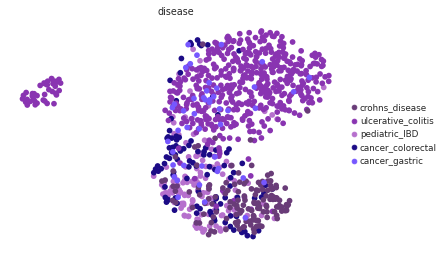

In [33]:
#plot umaps
sc.pl.umap(adata,color = 'disease',palette=[#'#ADD3DD',#control
                                    #'#ffb7b7',#'inutero',
                                     #'#f48154',#'preterm',
                                    '#693C78',#crohn's disease
                                            '#8934B1',#UC
                                            '#B670CD',#PIBD
                                            '#1C0B86',#colorectal cancer
                                            '#7657ff',#gastric cancer
                                           ])

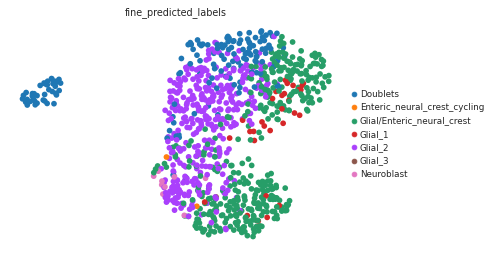

In [34]:
sc.pl.umap(adata, color=['fine_predicted_labels'])

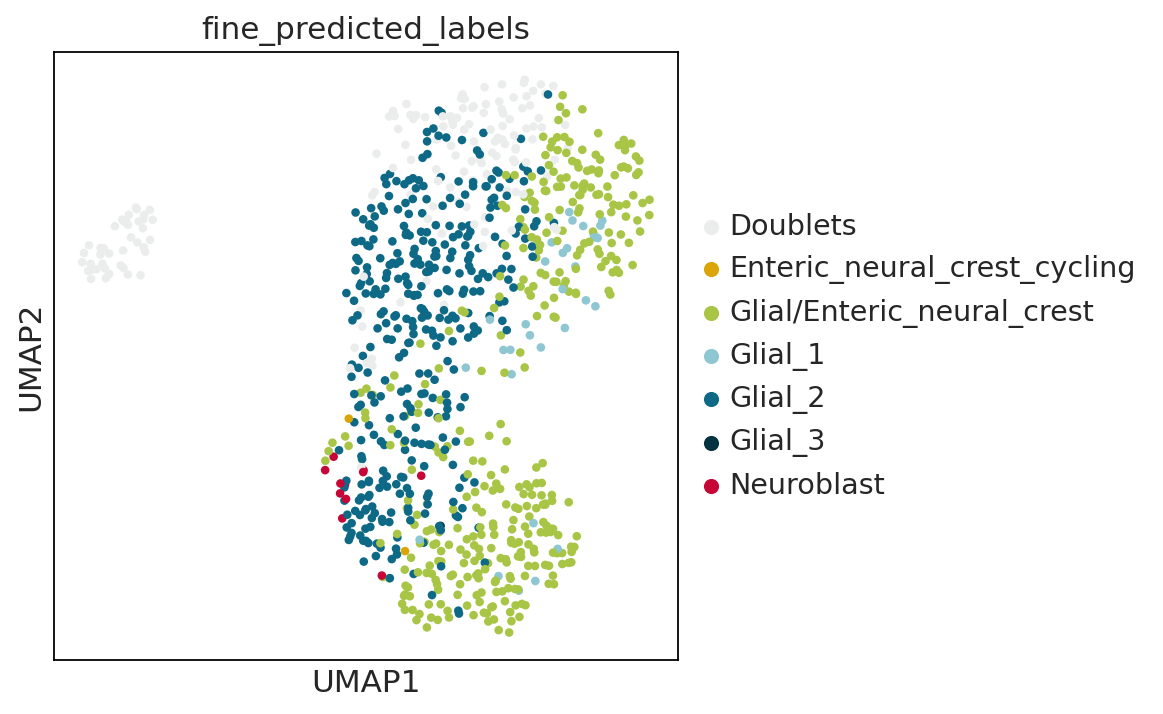

In [65]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels',palette = [
    '#ebeded',#doublets
    '#DBA507',#enteric neural crest (ENC)                                       
           '#a8c545',#glial/ENC, 
    '#8EC7D2',#glial1
           '#0D6986',#glial2
           '#053240',#glial3
    '#c50637'#neuroblast
          ]
           ,size=60)

In [39]:
adata.X.max()

2713.0

In [40]:
adata.layers['counts'] = adata.X

In [41]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


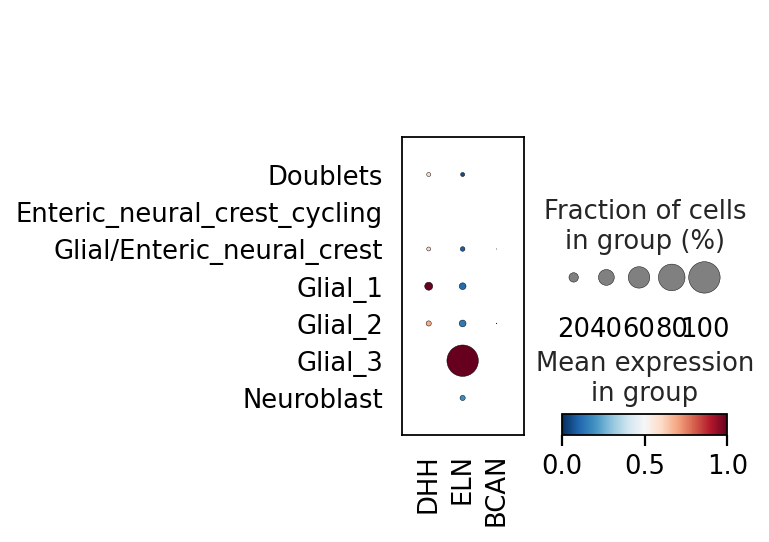

In [42]:
#plot markers
sc.set_figure_params(dpi_save = 300)
sc.pl.dotplot(adata,var_names=['DHH','ELN','BCAN'],groupby='fine_predicted_labels',color_map='RdBu_r', standard_scale='var')

### Define uncertain cells

In [59]:
uncert = adata.obs[['fine_predicted_labels','fine_predicted_labels_uncertainty']] 

In [44]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(adata.obs['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.6000240206718445


(array([40., 16., 15., 19., 29., 15., 26., 18., 50., 18., 26., 24., 42.,
        31., 37., 21., 38., 75., 36., 33., 34., 90., 40., 30., 36., 44.,
        22.,  5.,  7.,  1.]),
 array([0.        , 0.02466717, 0.04933435, 0.07400152, 0.09866869,
        0.12333587, 0.14800304, 0.17267022, 0.19733739, 0.22200456,
        0.24667174, 0.27133891, 0.29600608, 0.32067326, 0.34534043,
        0.3700076 , 0.39467478, 0.41934195, 0.44400913, 0.4686763 ,
        0.49334347, 0.51801065, 0.54267782, 0.56734499, 0.59201217,
        0.61667934, 0.64134651, 0.66601369, 0.69068086, 0.71534804,
        0.74001521]),
 <BarContainer object of 30 artists>)

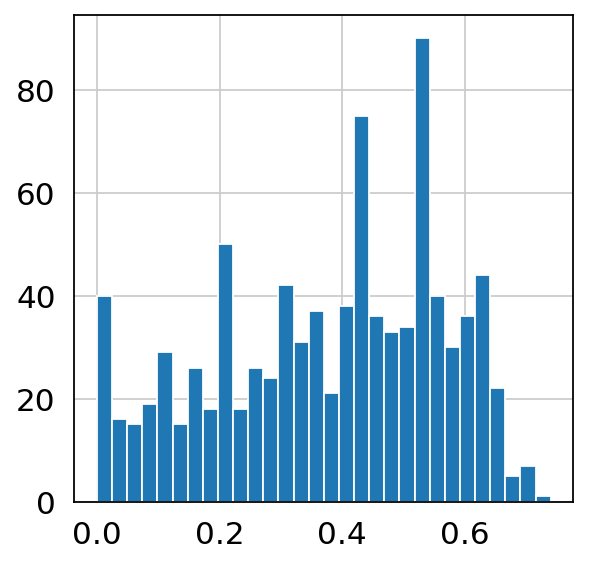

In [45]:
#plot uncertainty distribution
plt.hist(adata.obs['fine_predicted_labels_uncertainty'], bins=30)

In [60]:
uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')

<ipython-input-60-905f2ed234d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')


In [61]:
adata.obs['fine_predicted_labels'].unique()

['Glial_2', 'Glial/Enteric_neural_crest', 'Doublets', 'Glial_1', 'Neuroblast', 'Glial_3', 'Enteric_neural_crest_cycling']
Categories (7, object): ['Doublets', 'Enteric_neural_crest_cycling', 'Glial/Enteric_neural_crest', 'Glial_1', 'Glial_2', 'Glial_3', 'Neuroblast']

In [62]:
#mark cells are unknown based on cut off of 90th percentile
uncert.loc[uncert["fine_predicted_labels_uncertainty"] > p, "fine_predicted_labels"] = "Unknown"

In [63]:
adata.obs['fine_predicted_labels_uncertflagged'] = adata.obs['fine_predicted_labels']

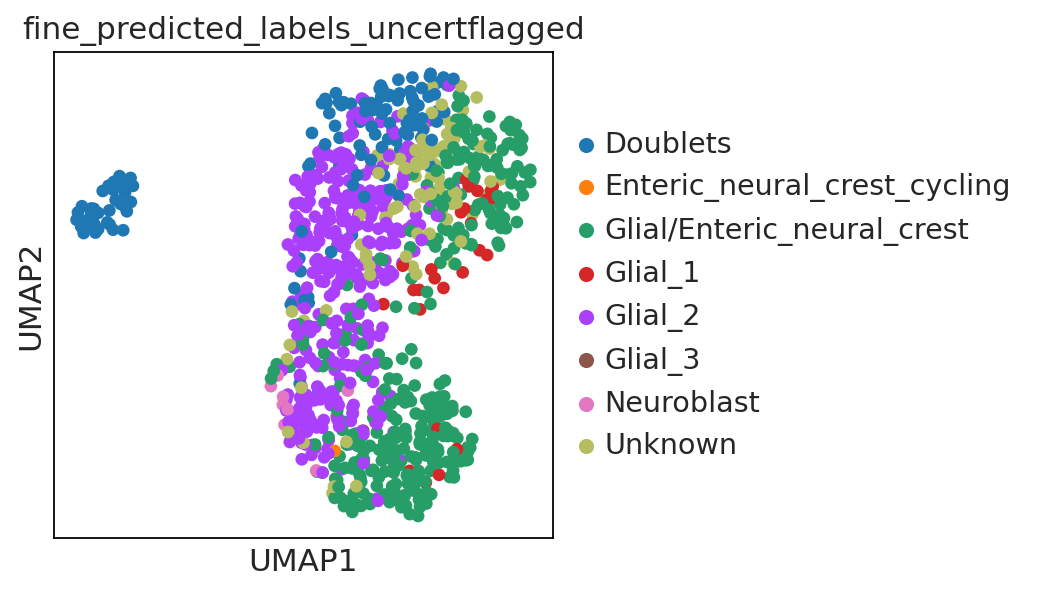

In [64]:
ON = {O:N for O,N in zip(uncert.index,uncert["fine_predicted_labels"])}
adata.obs["fine_predicted_labels_uncertflagged"] = [ON[O] if O in ON else N for O,N in zip(adata.obs_names, adata.obs["fine_predicted_labels_uncertflagged"])]
sc.pl.umap(adata,color='fine_predicted_labels_uncertflagged')

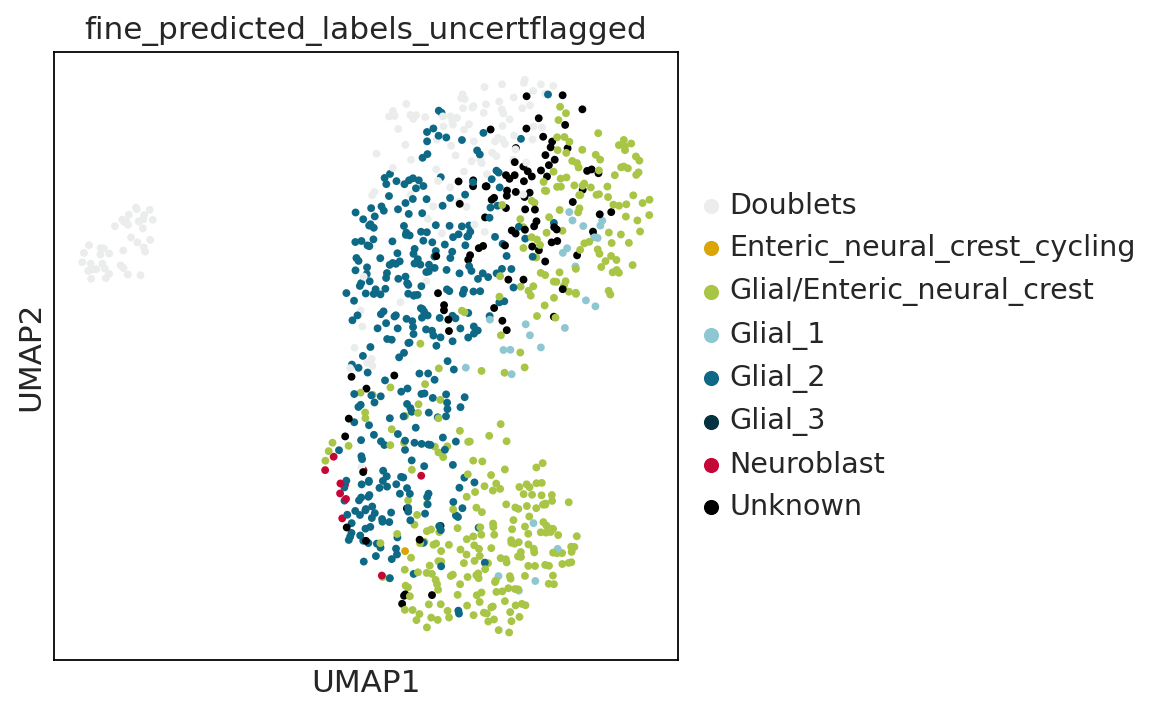

In [67]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels_uncertflagged',palette = ['#ebeded',#doublets
    '#DBA507',#enteric neural crest (ENC)                                       
           '#a8c545',#glial/ENC, 
    '#8EC7D2',#glial1
           '#0D6986',#glial2
           '#053240',#glial3
            '#c50637',#neuroblast
            '#000000'

                                                                       ],size=50)

### Finalise annotations
- calculate leiden clusters
- inspect annotations across leiden clusters
- assess marker genes, doublet markers, donor distribution
- relabel based on majority voting of leiden clusters, along with confirmation from marker genes etc.

In [68]:
#reassign labels for unknown cells by leiden clustering and majority voting
sc.tl.leiden(adata,resolution=1,key_added='leiden1')

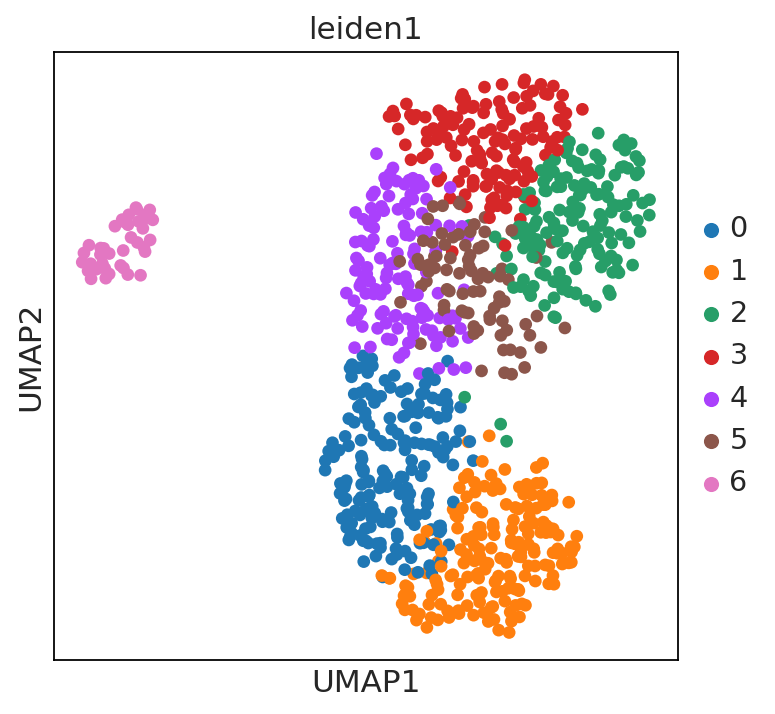

In [69]:
sc.pl.umap(adata,color='leiden1')

In [70]:
#quick look at leiden resolution 0.5
sc.tl.leiden(adata,resolution=0.5,key_added='leiden0.5')

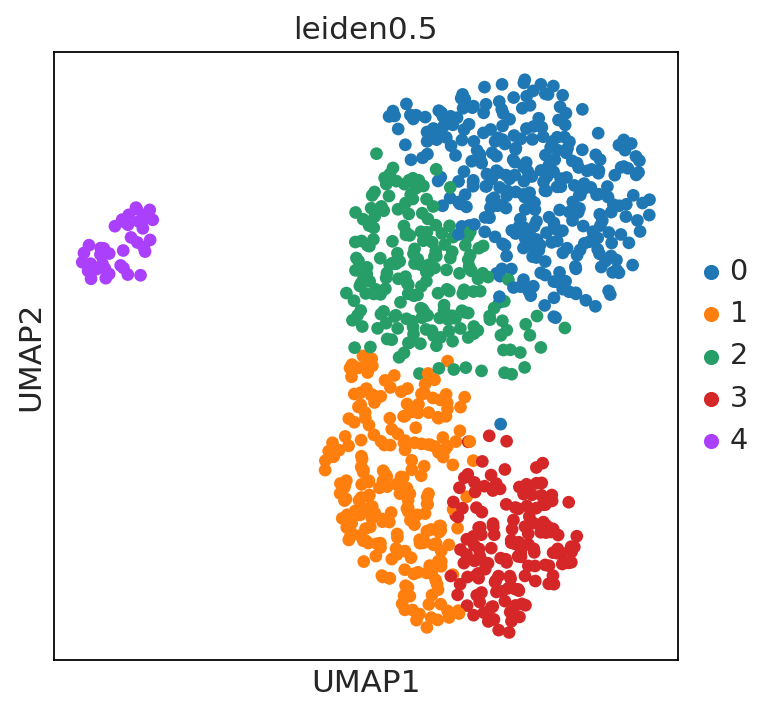

In [71]:
sc.pl.umap(adata,color='leiden0.5')

In [72]:
pd.crosstab(adata.obs.fine_predicted_labels_uncertflagged,adata.obs.leiden1)

leiden1,0,1,2,3,4,5,6
fine_predicted_labels_uncertflagged,,,,,,,
Doublets,6,0,1,68,11,9,40
Enteric_neural_crest_cycling,1,0,0,0,0,0,0
Glial/Enteric_neural_crest,44,160,102,9,1,12,0
Glial_1,0,5,13,0,1,8,0
Glial_2,115,13,12,27,117,37,0
Glial_3,1,0,0,0,0,0,0
Neuroblast,9,1,0,0,0,0,0
Unknown,9,5,30,33,2,16,0


In [73]:
pd.crosstab(adata.obs.fine_predicted_labels_uncertflagged,adata.obs['leiden0.5'])

leiden0.5,0,1,2,3,4
fine_predicted_labels_uncertflagged,,,,,
Doublets,72,6,17,0,40
Enteric_neural_crest_cycling,0,1,0,0,0
Glial/Enteric_neural_crest,113,72,10,133,0
Glial_1,13,0,9,5,0
Glial_2,42,120,150,9,0
Glial_3,0,1,0,0,0
Neuroblast,0,10,0,0,0
Unknown,67,14,14,0,0


In [74]:
#Use Leiden resolution 0.5
unknown = adata.obs[['leiden0.5','fine_predicted_labels_uncertflagged']]

In [75]:
unknown = unknown[unknown['fine_predicted_labels_uncertflagged'].isin(['Unknown'])]

In [76]:
unknown

,leiden0.5,fine_predicted_labels_uncertflagged
index,,
CATCGGGAGGTAGCTG-4918STDY7933270,1,Unknown
TAAGTGCAGAGATGAG-4918STDY7933270,0,Unknown
CAGATCACAATCGAAA-4918STDY7962470,1,Unknown
TGTGTTTCAATAGCAA-4918STDY7962470,1,Unknown
ACTGAACCACTAGTAC-scrEXT009,1,Unknown
...,...,...
GATGCTAGTGATAAGT-GSM5101020,0,Unknown
GGCGACTCATTCTTAC-GSM5101020,1,Unknown
ACCTTTACATCATCCC-GSM4546309,2,Unknown


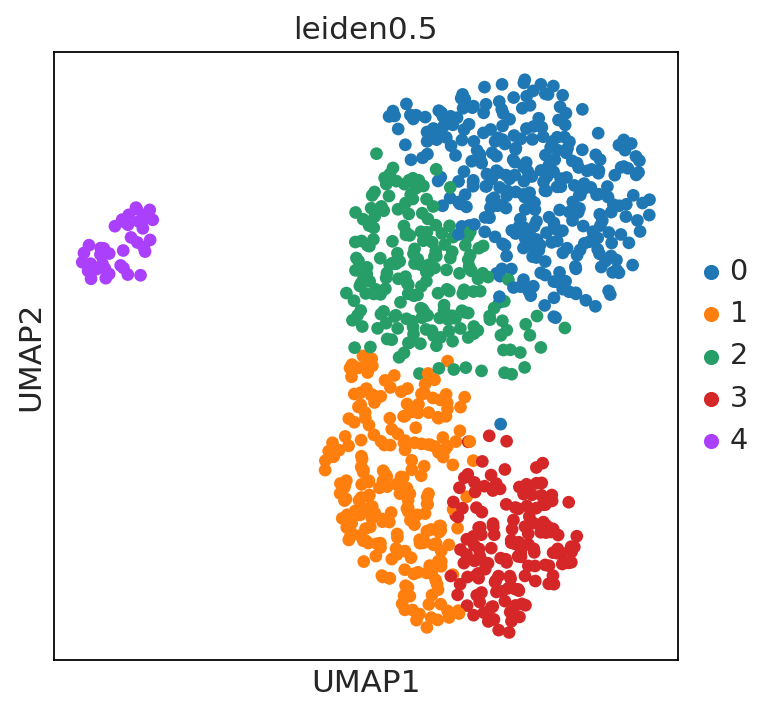

In [78]:
sc.pl.umap(adata,color='leiden0.5')

In [80]:
unknown_adata = adata[adata.obs['fine_predicted_labels_uncertflagged'].isin(['Unknown'])].copy()

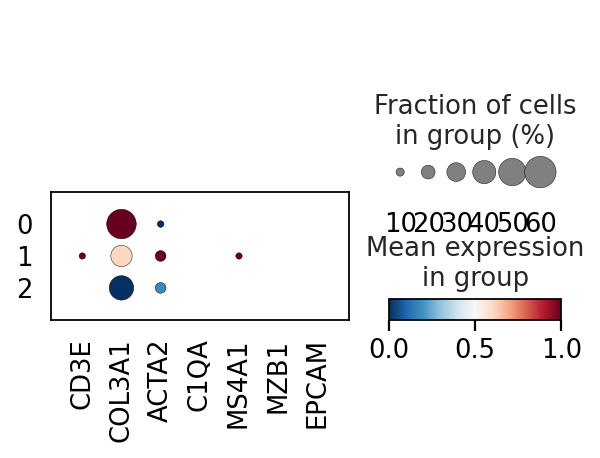

In [83]:
#plot some doublet markers
sc.pl.dotplot(unknown_adata,var_names=['CD3E','COL3A1','ACTA2','C1QA','MS4A1','MZB1','EPCAM'],groupby='leiden0.5',color_map='RdBu_r', standard_scale='var')

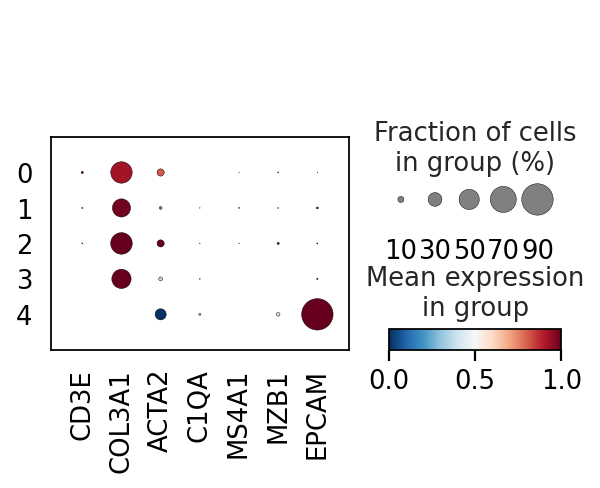

In [84]:
#plot some doublet markers
sc.pl.dotplot(adata,var_names=['CD3E','COL3A1','ACTA2','C1QA','MS4A1','MZB1','EPCAM'],groupby='leiden0.5',color_map='RdBu_r', standard_scale='var')

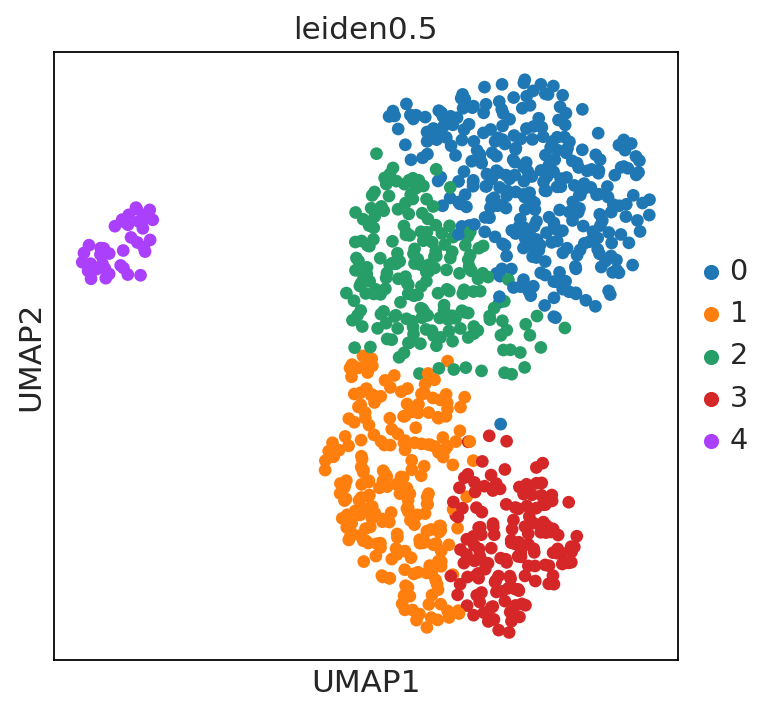

In [85]:
sc.pl.umap(adata,color='leiden0.5')

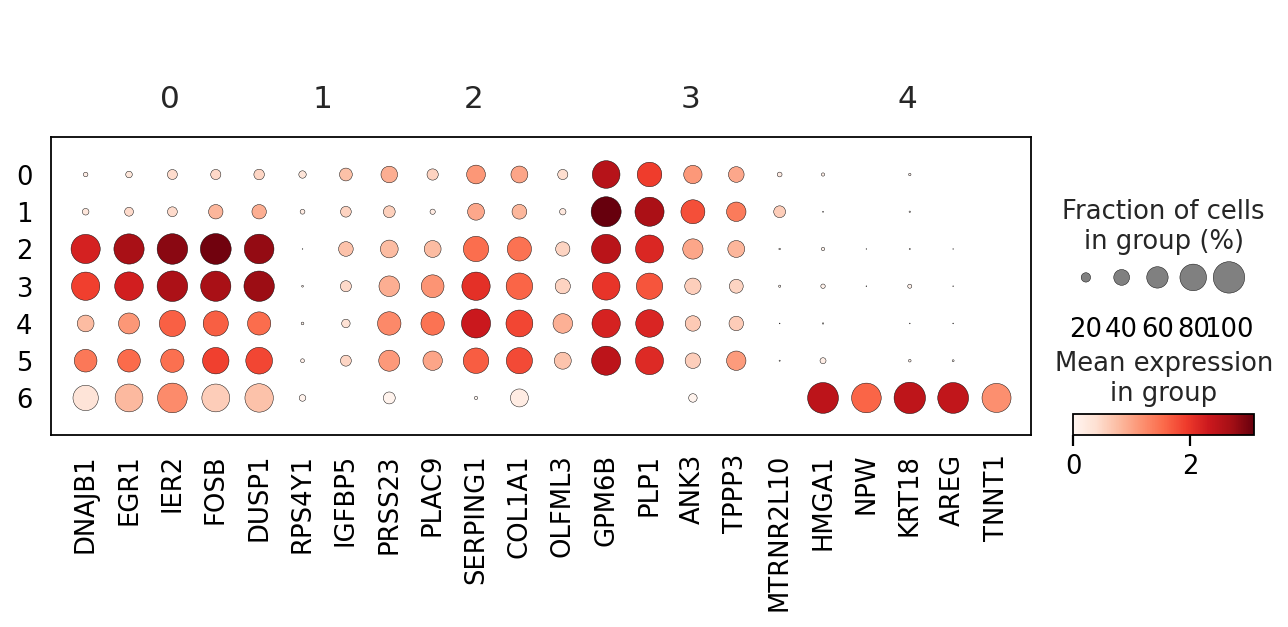

In [86]:
import sys
sys.path.append("/home/jovyan/ao15/Megagut/")
from re5_combine import *
adata.raw = adata.copy()
mkst = calc_marker_stats(adata, groupby="leiden0.5")
mks = filter_marker_stats(mkst[2], min_frac_diff=0.1, min_mean_diff=0.1, max_next_frac=0.5, max_next_mean=0.95, strict=False, how='or')
plot_markers(adata, groupby='leiden1', mks=mks)

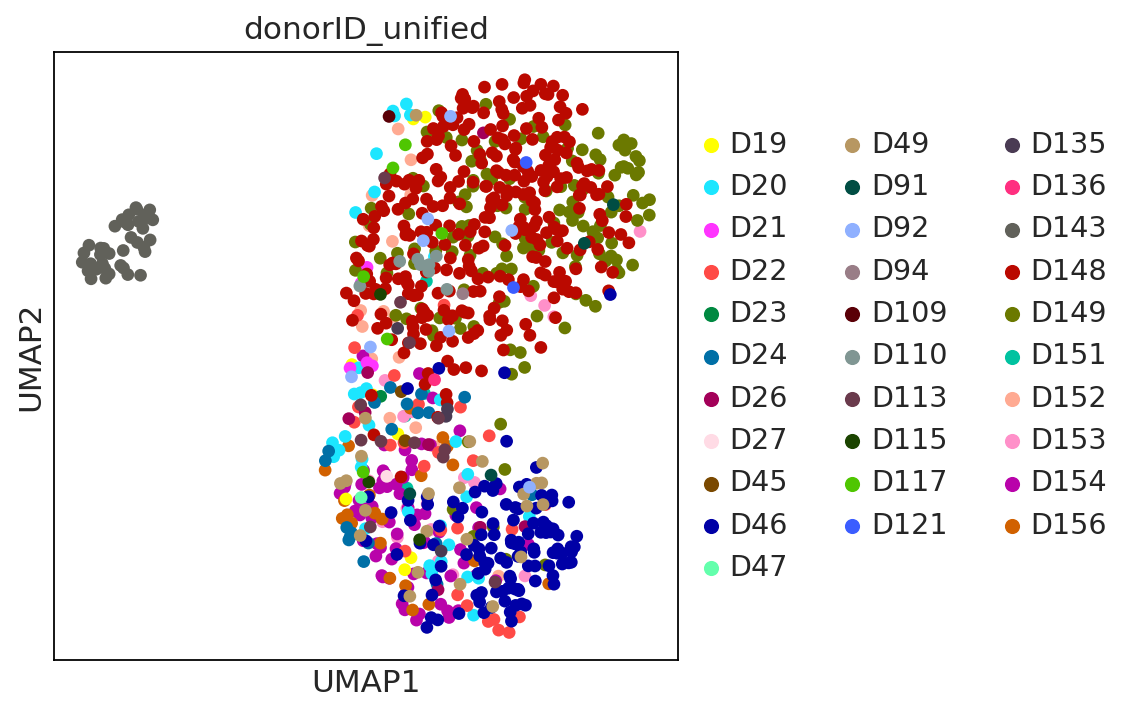

In [87]:
sc.pl.umap(adata,color='donorID_unified')

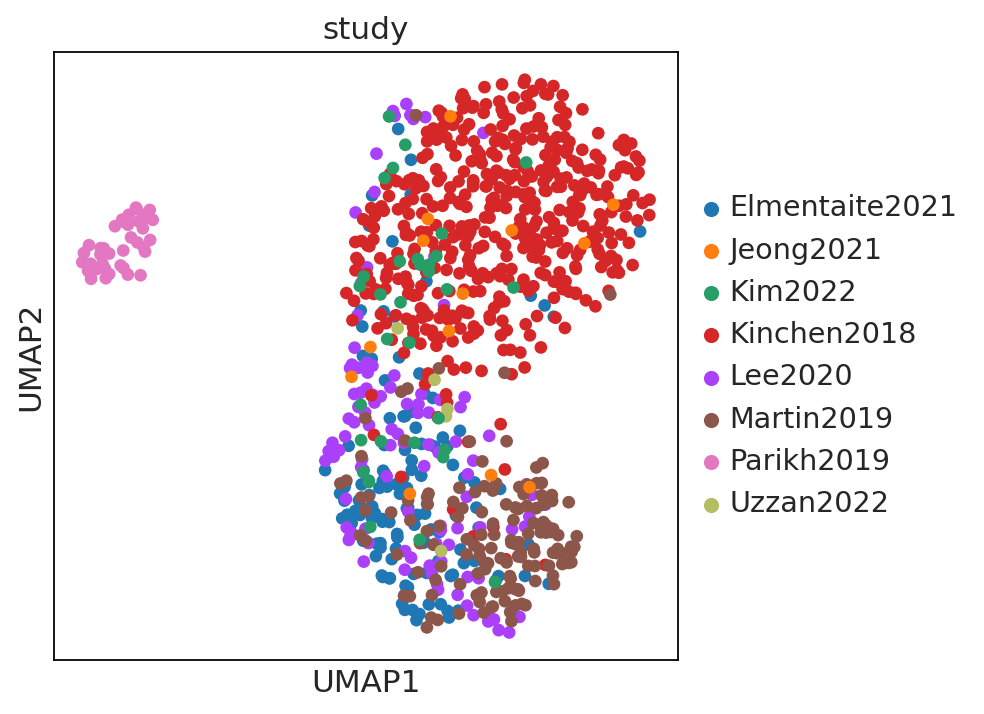

In [88]:
sc.pl.umap(adata,color='study')

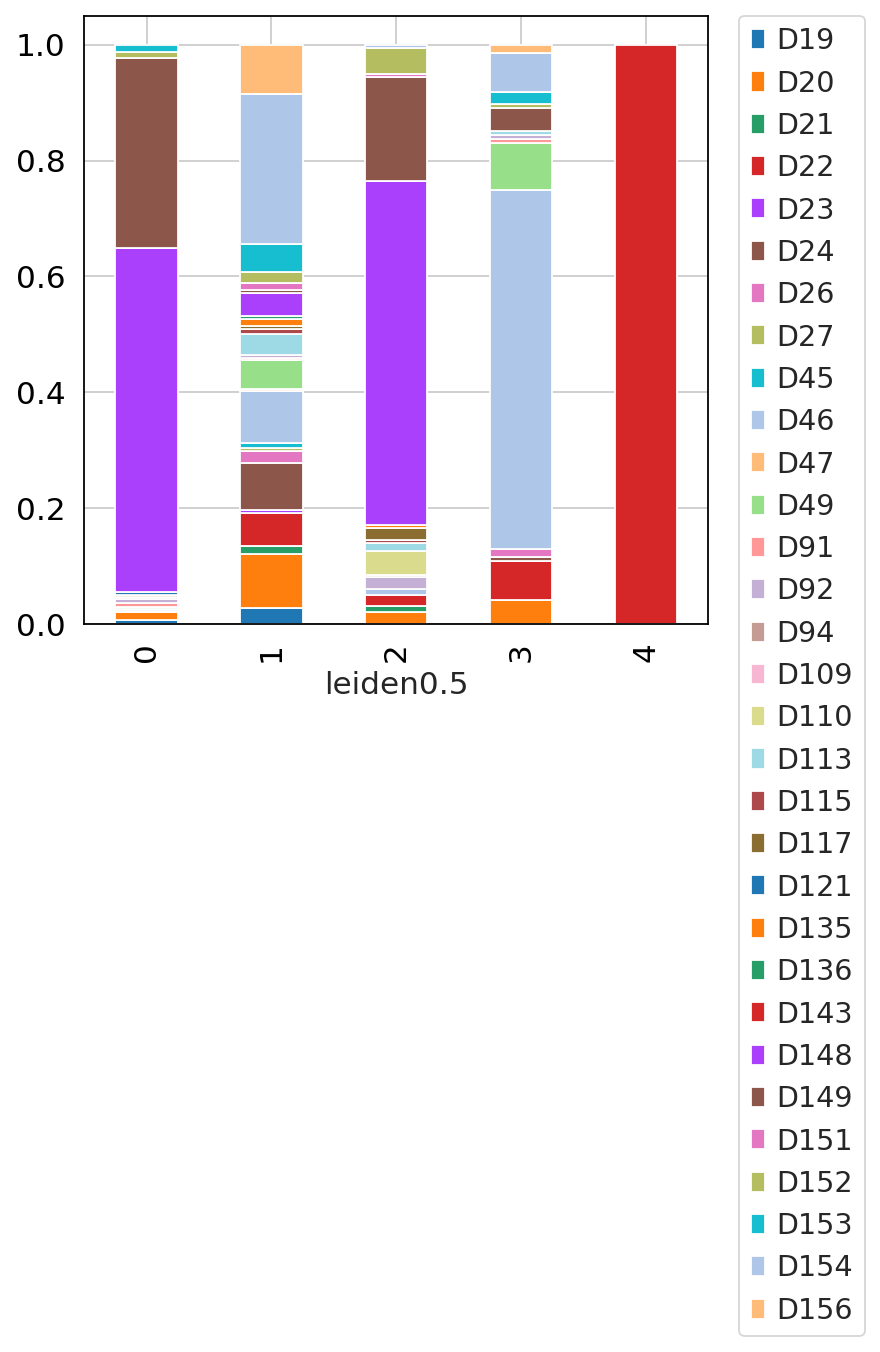

In [89]:
tmp = pd.crosstab(adata.obs['leiden0.5'], adata.obs['donorID_unified'],normalize='index'
                                                                         )
tmp.plot.bar(stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

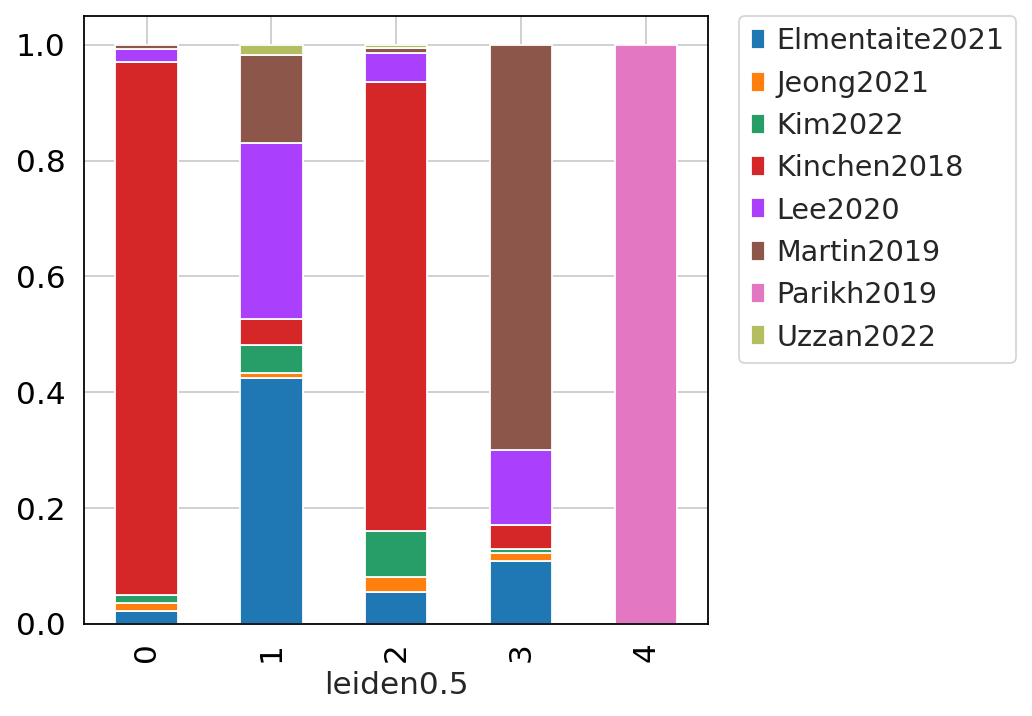

In [90]:
tmp = pd.crosstab(adata.obs['leiden0.5'], adata.obs['study'],normalize='index'
                                                                         )
tmp.plot.bar(stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

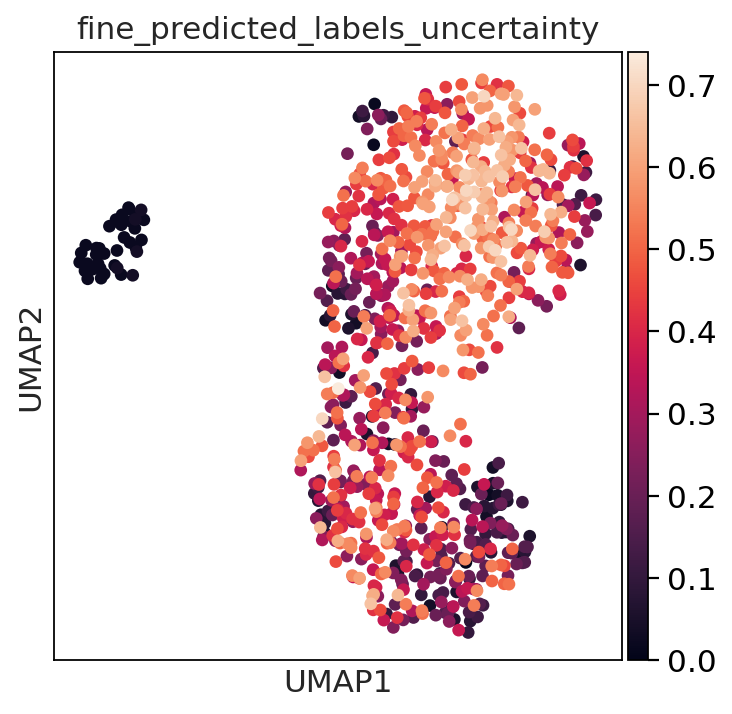

In [91]:
sc.pl.umap(adata,color='fine_predicted_labels_uncertainty')

In [93]:
pd.crosstab(adata.obs['leiden0.5'],adata.obs.disease)

disease,crohns_disease,ulcerative_colitis,pediatric_IBD,cancer_colorectal,cancer_gastric
leiden0.5,,,,,
0,2,283,7,7,8
1,34,14,95,68,13
2,2,156,11,10,21
3,103,6,16,19,3
4,0,40,0,0,0


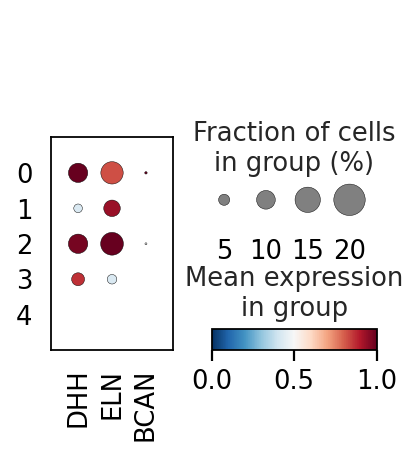

In [95]:
sc.pl.dotplot(adata,var_names=['DHH','ELN','BCAN'],groupby='leiden0.5',color_map='RdBu_r', standard_scale='var')

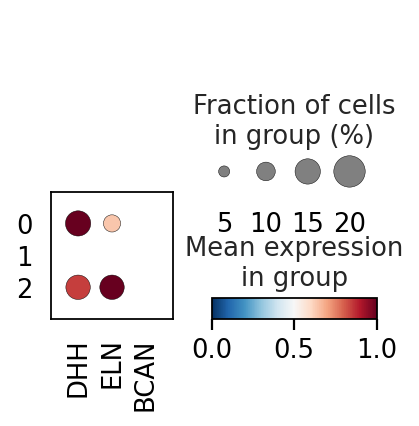

In [96]:
sc.pl.dotplot(unknown_adata,var_names=['DHH','ELN','BCAN'],groupby='leiden0.5',color_map='RdBu_r', standard_scale='var')

In [94]:
pd.crosstab(adata.obs.fine_predicted_labels_uncertflagged,adata.obs['leiden0.5'])

leiden0.5,0,1,2,3,4
fine_predicted_labels_uncertflagged,,,,,
Doublets,72,6,17,0,40
Enteric_neural_crest_cycling,0,1,0,0,0
Glial/Enteric_neural_crest,113,72,10,133,0
Glial_1,13,0,9,5,0
Glial_2,42,120,150,9,0
Glial_3,0,1,0,0,0
Neuroblast,0,10,0,0,0
Unknown,67,14,14,0,0


In [97]:
unknown['fine_predicted_labels_resolved'] = (unknown['leiden0.5']
        .map(lambda x:{'0':'Glial_1',
                       '1':'Glial_2',
                       '2':'Glial_2',
                         }.get(x,x)).astype('category'))

In [98]:
unknown

,leiden0.5,fine_predicted_labels_uncertflagged,fine_predicted_labels_resolved
index,,,
CATCGGGAGGTAGCTG-4918STDY7933270,1,Unknown,Glial_2
TAAGTGCAGAGATGAG-4918STDY7933270,0,Unknown,Glial_1
CAGATCACAATCGAAA-4918STDY7962470,1,Unknown,Glial_2
TGTGTTTCAATAGCAA-4918STDY7962470,1,Unknown,Glial_2
ACTGAACCACTAGTAC-scrEXT009,1,Unknown,Glial_2
...,...,...,...
GATGCTAGTGATAAGT-GSM5101020,0,Unknown,Glial_1
GGCGACTCATTCTTAC-GSM5101020,1,Unknown,Glial_2
ACCTTTACATCATCCC-GSM4546309,2,Unknown,Glial_2


In [99]:
adata

AnnData object with n_obs × n_vars = 918 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_splic

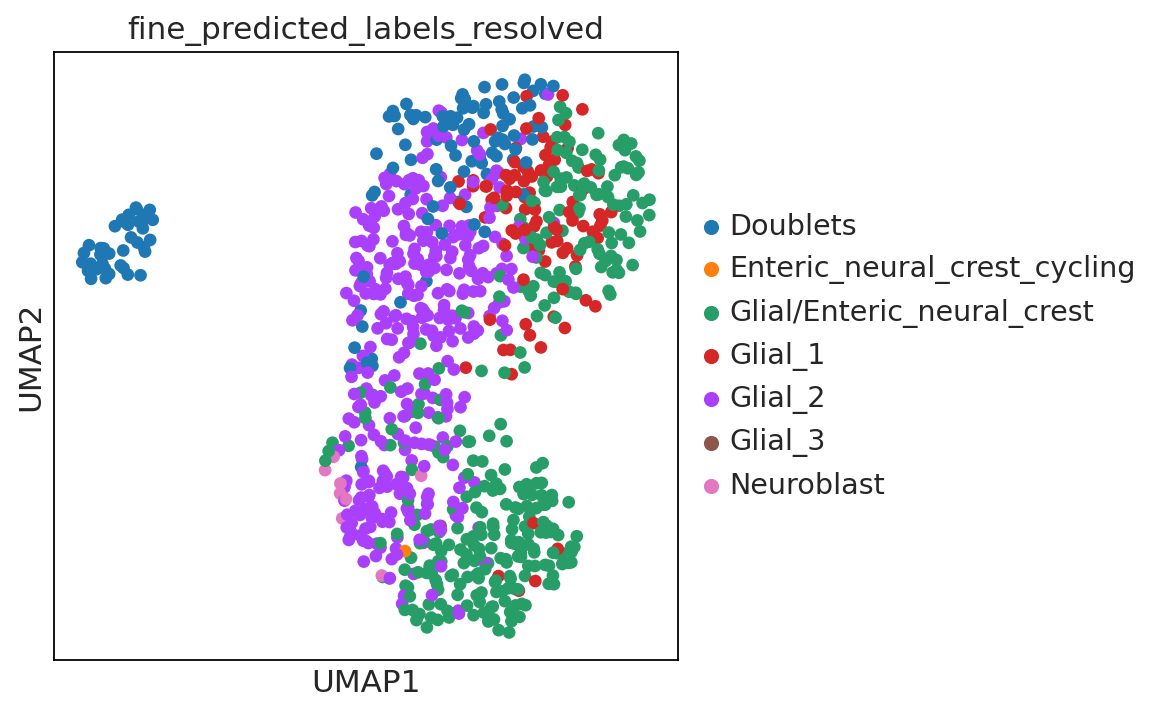

In [100]:
ON = {O:N for O,N in zip(unknown.index,unknown["fine_predicted_labels_resolved"])}
adata.obs["fine_predicted_labels_resolved"] = [ON[O] if O in ON else N for O,N in zip(adata.obs_names, adata.obs["fine_predicted_labels_uncertflagged"])]
sc.pl.umap(adata,color='fine_predicted_labels_resolved')

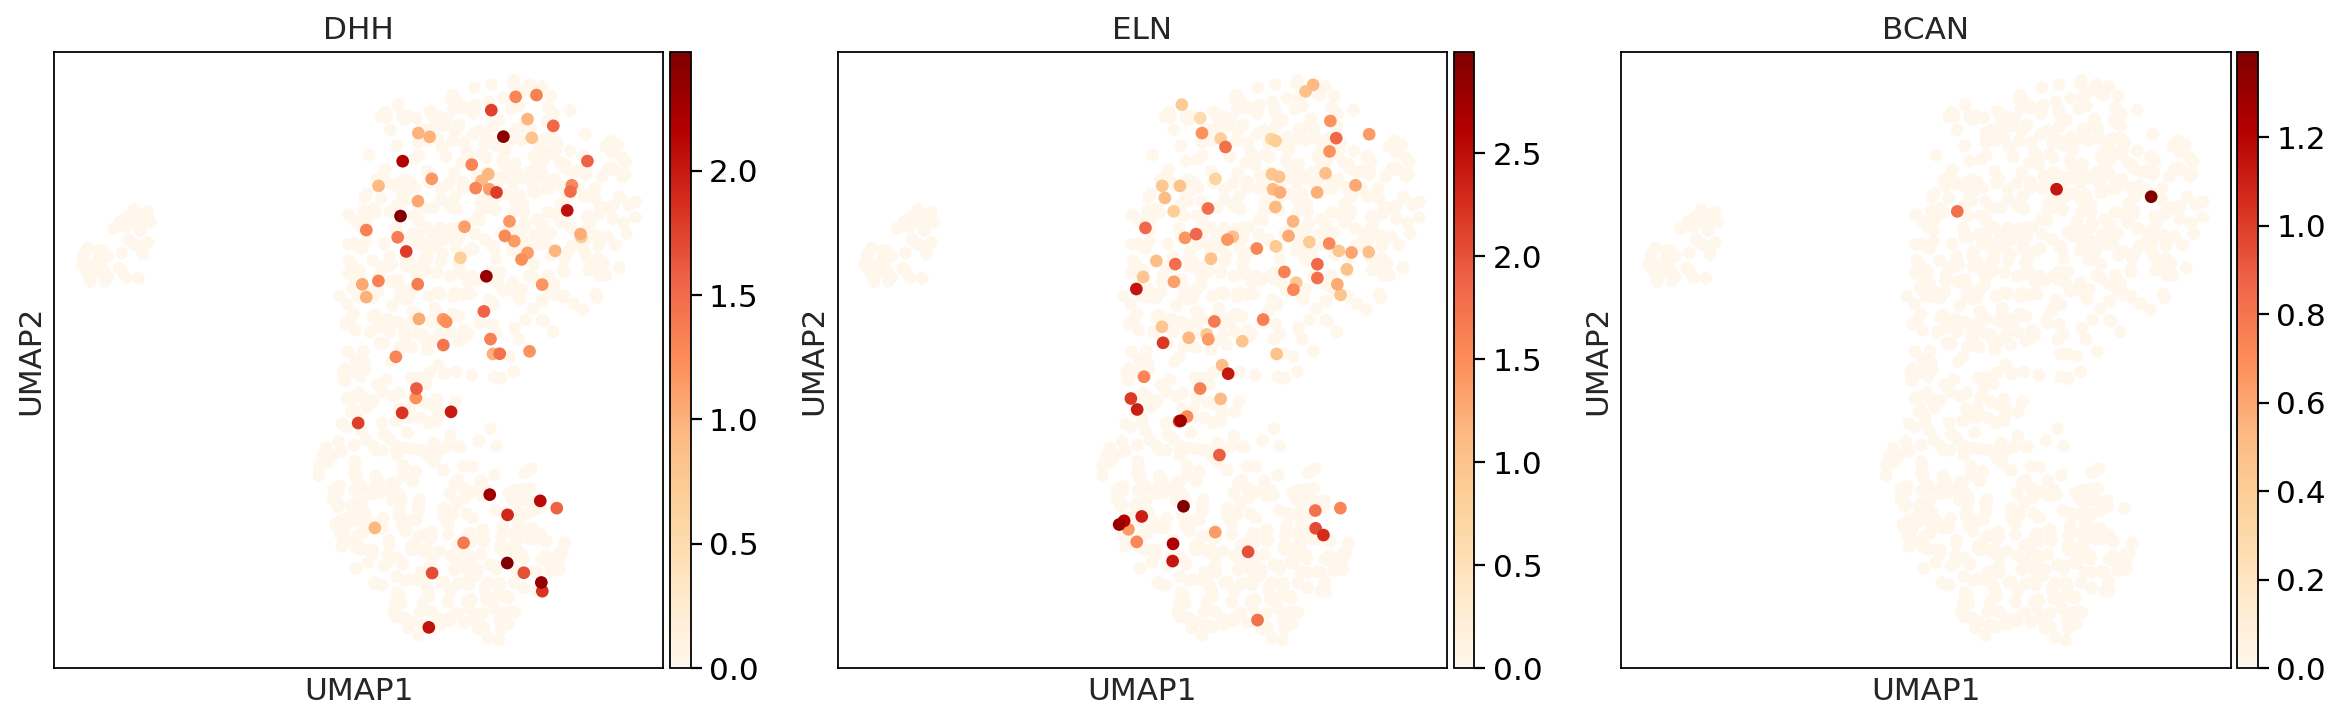

In [101]:
sc.pl.umap(adata,color=['DHH','ELN','BCAN'],cmap='OrRd')

In [102]:
no_doublets = adata[~adata.obs.fine_predicted_labels_resolved.isin(['Doublets'])].copy()

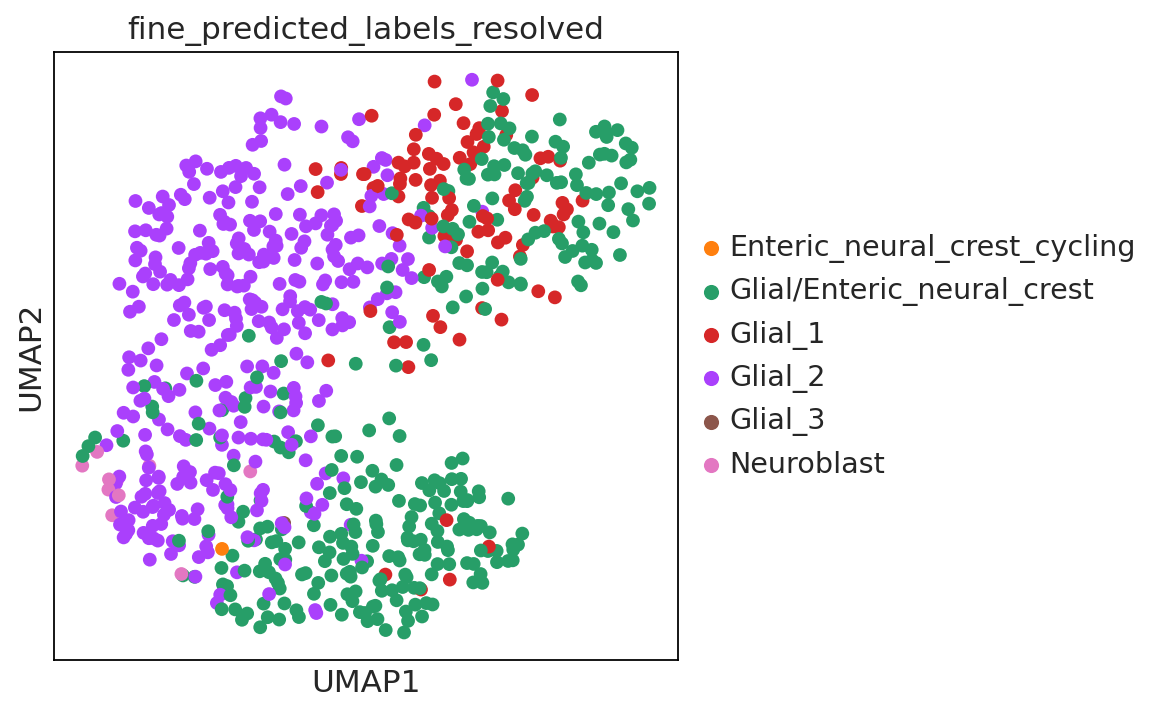

In [103]:
sc.pl.umap(no_doublets,color='fine_predicted_labels_resolved')

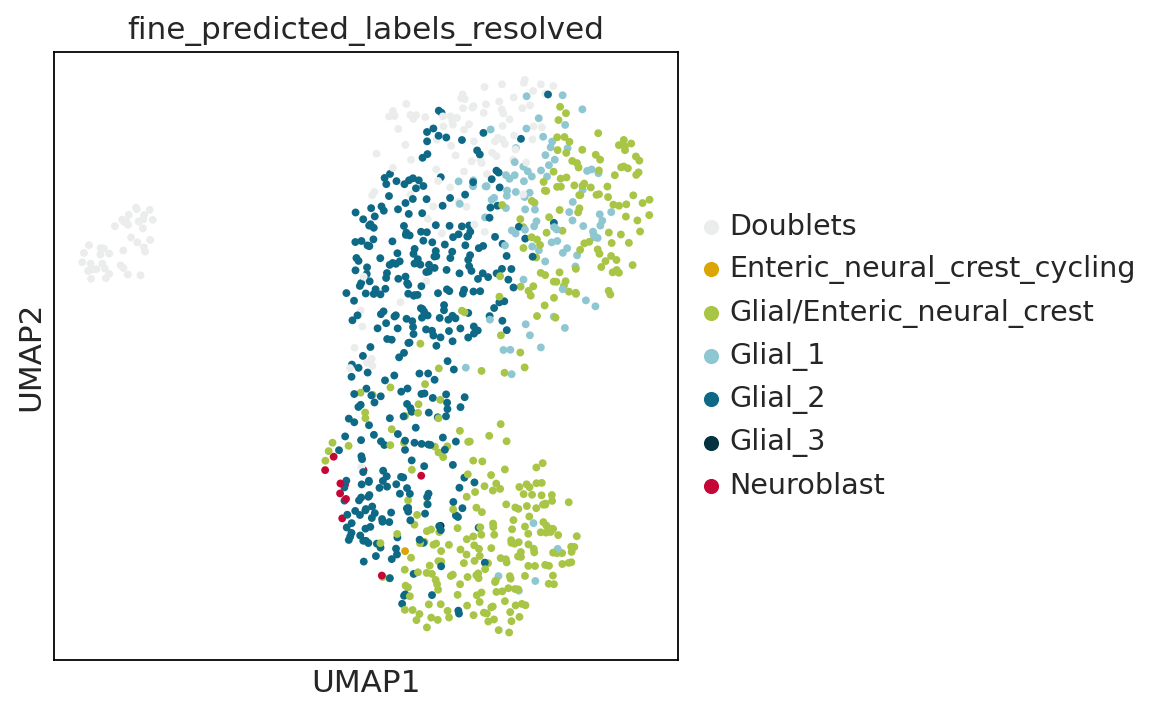

In [105]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels_resolved',palette = ['#ebeded',#doublets
    '#DBA507',#enteric neural crest (ENC)                                       
           '#a8c545',#glial/ENC, 
    '#8EC7D2',#glial1
           '#0D6986',#glial2
           '#053240',#glial3
            '#c50637'#neuroblast
    
                                              ],size=50)

In [106]:
annot = adata.obs[['fine_predicted_labels_uncertflagged','fine_predicted_labels_resolved']]

In [107]:
annot

,fine_predicted_labels_uncertflagged,fine_predicted_labels_resolved
index,,
AGATTGCCACGGCGTT-4918STDY7273965,Glial_2,Glial_2
CGCGGTACACCACCAG-4918STDY7273965,Glial/Enteric_neural_crest,Glial/Enteric_neural_crest
CGGCTAGGTCTAAACC-4918STDY7273965,Glial_2,Glial_2
TGTTCCGCACGTTGGC-4918STDY7273965,Doublets,Doublets
AAGCCGCTCATTGCGA-4918STDY7901096,Doublets,Doublets
...,...,...
TGACAACGTATTAGCC-GSM4546323,Doublets,Doublets
TGACAACGTGCAACTT-GSM4546323,Glial_2,Glial_2
TGGTTAGTCTGCAAGT-GSM4546323,Doublets,Doublets


In [109]:
#export final annotations
annot.to_csv('/nfs/team205/ao15/Megagut/Annotations_v3/disease_annot/resolved_annot/Neural_disease_annot.csv')